In [29]:
from pylabnet.hardware.zi_hdawg.zi_hdawg import HDAWGDriver, Sequence, AWGModule
from pylabnet.utils.logging.logger import LogClient

%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [30]:
dev_id = 'dev8040'

# Instantiate
logger = LogClient(
    host='localhost',
    port=12350,
    module_tag=f'ZI HDAWG {dev_id}'
)

In [17]:
# Instanciate Hardware class
hd = HDAWGDriver(dev_id, logger)

# Select channel grouping
hd.set_channel_grouping(0)


outputs = [0, 1]

# Enable the outputs and set corresponding ranges
hd.enable_output(outputs)
for output in outputs:
    hd.set_output_range(output, 0.2)

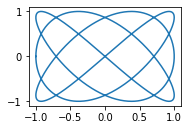

In [18]:
# Now let's try to output something cool, how about the following Lissajou figure?
a =3 
b = 4 
delta = np.pi/2
num_samples = 16*100 # Should be multiples of 16
t = np.linspace(-np.pi, np.pi, num_samples)


x = np.sin(a * t + delta)
y = np.sin(b * t)
plt.subplot(2, 2, 1)
plt.plot(x, y)

plt.show()

In [19]:
AWG_N = num_samples
sequence_txt = """\
        const AWG_N = _c1_;

        wave x = zeros(AWG_N);
        wave y = ones(AWG_N);

        while(1){
            setTrigger(1);
            setTrigger(0);
            playWave(1, x);
            playWave(2, y);
        }
        """

# Create Sequence Object and replace placeholder
seq = Sequence(hd, sequence_txt, ['c1'])
seq.replace_placeholder('c1', AWG_N)

In [20]:
# Create an instance of the AWG Module
awg = AWGModule(hd, 0)
awg.set_sampling_rate('2.4 GHz') # Set 2.4 GHz sampling rate

# Upload sequence
if awg is not None:
    awg.compile_upload_sequence(seq)

In [21]:
# Now let's upload it to the HDAWG
awg.dyn_waveform_upload(index=0, waveform1=x)
awg.dyn_waveform_upload(index=1, waveform1=y)

# Start the AWG
awg.start()

Let's now look at the signal output on the scope. The connections have been made as follows:

HDAWG           <-----> Oscilloscope<br/>
wave output 1   <-----> Channel 1<br/>
Wave output 2   <-----> Channel 2<br/>
marker output 1 <-----> Channel 3<br/>

The scope trigger should be set to output 3.

A look in the scope shows us that the two waveforms for x, y are played sequentially, as was to be expected.  This will not work for our purpose, we'll need to find a way to ensure synchronous wave playback.

![alt text](pictures/TEK0000.bmp "Title")

In [22]:
# Stop the AWG
awg.stop()

# Let's use one playWave command for both x and y:
# This should play x on output 0 and y on output 1
sequence_txt_new = """\
        const AWG_N = _c1_;
        wave x = zeros(AWG_N);
        wave y = ones(AWG_N);
        

        while(1){
            setTrigger(1);
            setTrigger(0);
            playWave(x, y);
  }
        """

# Create Sequence Object and replace placeholder
seq_new = Sequence(hd, sequence_txt_new, ['c1'])
seq_new.replace_placeholder('c1', AWG_N)

# Upload sequence
awg.compile_upload_sequence(seq_new)

In [23]:
# Now let's upload it to the HDAWG
awg.dyn_waveform_upload(index=0, waveform1=x)
awg.dyn_waveform_upload(index=1, waveform1=y)

RuntimeError: ZIAPIServerException with status code: 36878. Vector transfer error, data have different length than expected

We see that dynamic waveform upload fails, because the `playWave` commands does transform the two single waveforms `x` and `y` into one combined waveform adressing two outputs. The two single waveforms cannot be addressed individually anymore. The correct way to address the new combined waveform is using index 0 rand using a single `dyn_waveform_upload` with both `x` and `y` waveforms as argument: 

In [24]:
# Let's dynamically change the combined waveform.
awg.dyn_waveform_upload(index=0, waveform1=x, waveform2=y)

# Start the AWG
awg.start()

Now, a look in the scope shows that both wavefroms `x` and `y` are played back simultaneously:
![alt text](pictures/TEK0001.bmp "Title")

And, finally, switching the scope to XY mode shows the Lissajou figure:
![alt text](pictures/TEK0002.bmp "Title")

Another way to assign waveforms is to hard-copy the array into the sequencer instructions, as is demonstrated below. This should not be done for waveforms with more than 100 entries, but for demonstration purposees, we'll do it anyway:

In [25]:
# Start the AWG
awg.stop()

# Let's use one playWave command for both x and y:
# This should play x on output 0 and y on output 1
sequence_txt_new = """\
        const AWG_N = _c1_;
        wave x = _xwave_;
        wave y = _ywave_;
        

        while(1){
            setTrigger(1);
            setTrigger(0);
            playWave(x, y);
  }
        """

# Create Sequence Object and replace placeholder
seq_new = Sequence(hd, sequence_txt_new, ['c1', 'xwave', 'ywave'])
seq_new.replace_placeholder('c1', AWG_N)

# Replace waveform placeholders
seq_new.replace_waveform('xwave', x)
seq_new.replace_waveform('ywave', y)

In [26]:
print(seq_new.sequence)

      const AWG_N = 1600;
      wave x = vect(-1.0,-0.9999305183227262,-0.9997220829463118,-0.9993747228356358,-0.9988884862610246,-0.9982634407915436,-0.997499673285608,-0.9965972898789124,-0.995556415969682,-0.9943771962012475,-0.9930597944419431,-0.9916043937623368,-0.990011196409789,-0.9882804237803484,-0.9864123163879857,-0.9844071338311705,-0.982265154756798,-0.9799866768214647,-0.9775720166501088,-0.9750215097920072,-0.9723355106741488,-0.9695143925519814,-0.9665585474575428,-0.9634683861449828,-0.9602443380334835,-0.9568868511475864,-0.9533963920549302,-0.9497734458014211,-0.9460185158438231,-0.9421321239798,-0.938114810275401,-0.9339671329900153,-0.9296896684987922,-0.9252830112125463,-0.9207477734951564,-0.9160845855784693,-0.911294095474721,-0.9063769688864859,-0.9013338891141707,-0.8961655569610558,-0.8908726906359157,-0.8854560256532091,-0.8799163147308751,-0.8742543276857241,-0.8684708513264701,-0.8625666893443898,-0.8565426622016356,-0.8503996070172295,-0.844138377450726

In [28]:
# Upload sequence
awg.compile_upload_sequence(seq_new)


# Start the AWG
awg.start()
# Again, the correct Lissajous figure is played back.